In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 23
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

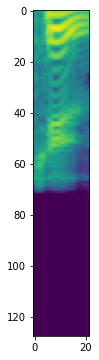

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.9763837185481189
TEST
loss: 0.6641334008145076
accuracy: 0.7913978494623656
******************
epoch: 1
Train
0.3195592702462202
TEST
loss: 0.41540239664816087
accuracy: 0.886021505376344
******************
epoch: 2
Train
0.2685438179494748
TEST
loss: 0.3979835797381657
accuracy: 0.8709677419354839
******************
epoch: 3
Train
0.20067770905114657
TEST
loss: 0.290929502184673
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.19261369738260392
TEST
loss: 0.32145952511859194
accuracy: 0.9182795698924732
******************
epoch: 5
Train
0.16834183692867935
TEST
loss: 0.5329755027007351
accuracy: 0.875268817204301
******************
epoch: 6
Train
0.15573058699046533
TEST
loss: 0.16980878837126237
accuracy: 0.9526881720430107
******************
epoch: 7
Train
0.12516862336560225
TEST
loss: 0.46896156341798845
accuracy: 0.8881720430107527
******************
epoch: 8
Train
0.13787753435877875
TEST
loss: 0.32630030090610185
accuracy: 0.9053763440860215
***

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


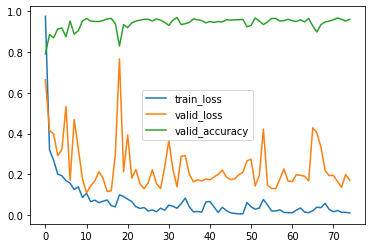

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9941955905610281
TEST
loss: 0.37350978671863516
accuracy: 0.8709677419354839
******************
epoch: 1
Train
0.3753594249952334
TEST
loss: 0.25010526537574745
accuracy: 0.9118279569892473
******************
epoch: 2
Train
0.28122262618974386
TEST
loss: 0.29576604434799764
accuracy: 0.9032258064516129
******************
epoch: 3
Train
0.22714737678768177
TEST
loss: 0.24854125720198436
accuracy: 0.9161290322580645
******************
epoch: 4
Train
0.2589029263731094
TEST
loss: 0.5193022683743508
accuracy: 0.8602150537634409
******************
epoch: 5
Train
0.23197559103185153
TEST
loss: 0.3292769133403737
accuracy: 0.9010752688172043
******************
epoch: 6
Train
0.20468444370363242
TEST
loss: 0.29667110989491147
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.18577555906053633
TEST
loss: 0.28677427191888133
accuracy: 0.9139784946236559
******************
epoch: 8
Train
0.17233832016001482
TEST
loss: 0.328977794288307

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


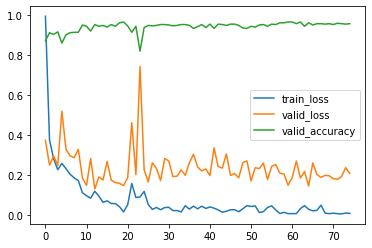

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0455734541034853
TEST
loss: 0.583943921583955
accuracy: 0.8602150537634409
******************
epoch: 1
Train
0.4455152794309502
TEST
loss: 0.3306556990069728
accuracy: 0.8946236559139785
******************
epoch: 2
Train
0.30962891683311444
TEST
loss: 0.6370454016552176
accuracy: 0.8150537634408602
******************
epoch: 3
Train
0.26337287197462256
TEST
loss: 0.3439514068506097
accuracy: 0.9075268817204301
******************
epoch: 4
Train
0.26363400615025545
TEST
loss: 0.35165937259312596
accuracy: 0.8924731182795699
******************
epoch: 5
Train
0.2748904683991793
TEST
loss: 0.34717216885858965
accuracy: 0.9010752688172043
******************
epoch: 6
Train
0.2239919859167704
TEST
loss: 0.19732045574534324
accuracy: 0.9376344086021505
******************
epoch: 7
Train
0.1680686393924214
TEST
loss: 0.2327340208715008
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.14686903954515165
TEST
loss: 0.12552748622512946
acc

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


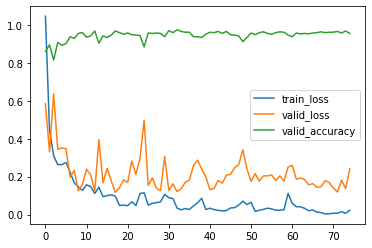

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8715194057378323
TEST
loss: 0.4587577906827773
accuracy: 0.8516129032258064
******************
epoch: 1
Train
0.3536211826753796
TEST
loss: 0.4787578342422362
accuracy: 0.8365591397849462
******************
epoch: 2
Train
0.25782099884559084
TEST
loss: 0.5155244419651647
accuracy: 0.8344086021505376
******************
epoch: 3
Train
0.26210687278609923
TEST
loss: 0.3354701769608323
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.1646408039392421
TEST
loss: 0.2500945012816178
accuracy: 0.9290322580645162
******************
epoch: 5
Train
0.10911102283206368
TEST
loss: 0.12473388388352369
accuracy: 0.9655913978494624
******************
epoch: 6
Train
0.12795089523061734
TEST
loss: 0.42844833879060645
accuracy: 0.8709677419354839
******************
epoch: 7
Train
0.20837698058377174
TEST
loss: 0.3021209479980571
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.1267832489779513
TEST
loss: 0.23118763570823977
acc

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


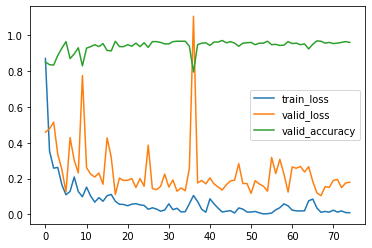

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9626383903402761
TEST
loss: 0.611454780223549
accuracy: 0.8580645161290322
******************
epoch: 1
Train
0.32935250665657484
TEST
loss: 0.5420783680613322
accuracy: 0.8731182795698925
******************
epoch: 2
Train
0.26262971956240727
TEST
loss: 0.7567127018846491
accuracy: 0.8064516129032258
******************
epoch: 3
Train
0.285580315823252
TEST
loss: 0.5162780100299466
accuracy: 0.8559139784946237
******************
epoch: 4
Train
0.17348765100788288
TEST
loss: 0.437375659407467
accuracy: 0.8623655913978494
******************
epoch: 5
Train
0.17060286796455687
TEST
loss: 0.30364099100071895
accuracy: 0.9096774193548387
******************
epoch: 6
Train
0.15846930363997375
TEST
loss: 0.33580380676574606
accuracy: 0.896774193548387
******************
epoch: 7
Train
0.17309669188565313
TEST
loss: 0.5633525785579476
accuracy: 0.8580645161290322
******************
epoch: 8
Train
0.18085442909516503
TEST
loss: 0.344123273623246
accura

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


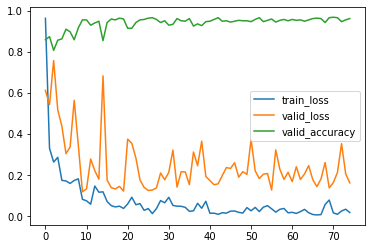

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.1011969260008796
TEST
loss: 0.5329293871438632
accuracy: 0.8623655913978494
******************
epoch: 1
Train
0.38308457356983444
TEST
loss: 0.29884057150733084
accuracy: 0.9032258064516129
******************
epoch: 2
Train
0.3321618870759306
TEST
loss: 0.27168347173801033
accuracy: 0.9225806451612903
******************
epoch: 3
Train
0.25587021548644023
TEST
loss: 0.6844075956652241
accuracy: 0.8236559139784946
******************
epoch: 4
Train
0.2878646860536094
TEST
loss: 0.32410561077056393
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.2554014932743374
TEST
loss: 0.34641167326399713
accuracy: 0.9075268817204301
******************
epoch: 6
Train
0.1664679758190531
TEST
loss: 0.13684240009195062
accuracy: 0.946236559139785
******************
epoch: 7
Train
0.20497265109450316
TEST
loss: 0.25097851836553187
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.17834325376687413
TEST
loss: 0.2870699246724447
a

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


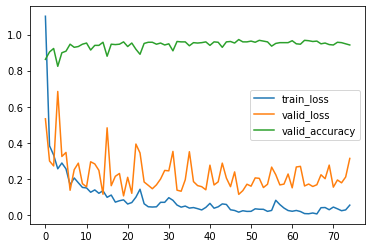

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.9339617871442147
TEST
loss: 2.1254798084177
accuracy: 0.5634408602150538
******************
epoch: 1
Train
1.3497750834232385
TEST
loss: 0.7333286513564408
accuracy: 0.8
******************
epoch: 2
Train
1.2235783577992445
TEST
loss: 0.506226792386783
accuracy: 0.8301075268817204
******************
epoch: 3
Train
1.1489097545014701
TEST
loss: 1.2391113081286032
accuracy: 0.7290322580645161
******************
epoch: 4
Train
1.0905005933138139
TEST
loss: 0.4186196022136237
accuracy: 0.8817204301075269
******************
epoch: 5
Train
1.015332495967226
TEST
loss: 0.3747021425795811
accuracy: 0.8989247311827957
******************
epoch: 6
Train
1.0249961815537723
TEST
loss: 0.6100992710359635
accuracy: 0.8408602150537634
******************
epoch: 7
Train
0.9380473986901965
TEST
loss: 0.5191391128365711
accuracy: 0.8408602150537634
******************
epoch: 8
Train
0.90531247226731
TEST
loss: 0.3101421185558842
accuracy: 0.9139784946236559
***

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9173838209982789


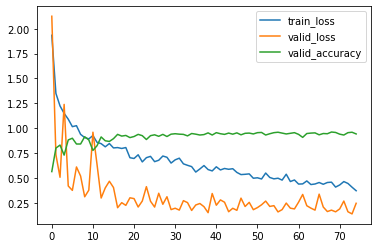

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.4893733855531495
TEST
loss: 2.0697148282040834
accuracy: 0.35913978494623655
******************
epoch: 1
Train
0.6587894014215752
TEST
loss: 1.7679226783014113
accuracy: 0.546236559139785
******************
epoch: 2
Train
0.5323627210780376
TEST
loss: 1.1075649358892954
accuracy: 0.6451612903225806
******************
epoch: 3
Train
0.44866631389883943
TEST
loss: 0.7600848247928004
accuracy: 0.7268817204301076
******************
epoch: 4
Train
0.42316572243768036
TEST
loss: 0.515878951164984
accuracy: 0.8279569892473119
******************
epoch: 5
Train
0.37319616187819243
TEST
loss: 0.454084853587612
accuracy: 0.853763440860215
******************
epoch: 6
Train
0.2804215350456628
TEST
loss: 0.6552187881162089
accuracy: 0.8064516129032258
******************
epoch: 7
Train
0.23641226449494857
TEST
loss: 0.47047781957093104
accuracy: 0.8301075268817204
******************
epoch: 8
Train
0.22817949918998975
TEST
loss: 0.5664507284600248
accurac

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9104991394148021


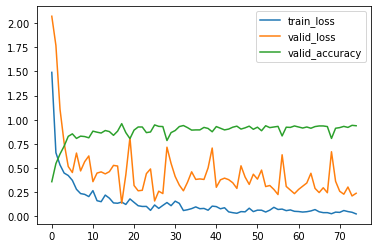

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8978042462594932
TEST
loss: 0.4774612970249627
accuracy: 0.8451612903225807
******************
epoch: 1
Train
0.3573670347467442
TEST
loss: 0.4883117550162859
accuracy: 0.8387096774193549
******************
epoch: 2
Train
0.34091968143506274
TEST
loss: 0.5064667546941388
accuracy: 0.8516129032258064
******************
epoch: 3
Train
0.215603149059195
TEST
loss: 0.3157696451871626
accuracy: 0.8924731182795699
******************
epoch: 4
Train
0.18239408063837195
TEST
loss: 0.16934106748911643
accuracy: 0.9419354838709677
******************
epoch: 5
Train
0.1712862537731454
TEST
loss: 0.25629710228212416
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.2036410187705589
TEST
loss: 0.28001042436207496
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.14696736841005667
TEST
loss: 0.2057999425036933
accuracy: 0.9118279569892473
******************
epoch: 8
Train
0.1367780351404484
TEST
loss: 0.22923252239663114
accu

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


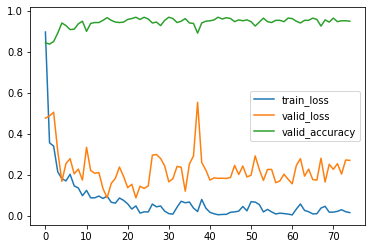

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9274000399332247
TEST
loss: 0.5802740805892534
accuracy: 0.8408602150537634
******************
epoch: 1
Train
0.4131355343419631
TEST
loss: 0.6818563958649995
accuracy: 0.8150537634408602
******************
epoch: 2
Train
0.2649454361145767
TEST
loss: 0.4456771153916595
accuracy: 0.8473118279569892
******************
epoch: 3
Train
0.23324648025668818
TEST
loss: 0.2838847890015571
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.17971772076657336
TEST
loss: 0.16841109243562064
accuracy: 0.9397849462365592
******************
epoch: 5
Train
0.1336046114491723
TEST
loss: 0.3197320986378898
accuracy: 0.9139784946236559
******************
epoch: 6
Train
0.14057252825301503
TEST
loss: 0.3511711339155833
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.12754914848215168
TEST
loss: 0.49463183674761046
accuracy: 0.8795698924731182
******************
epoch: 8
Train
0.11783896271875614
TEST
loss: 0.24925525630674056
ac

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


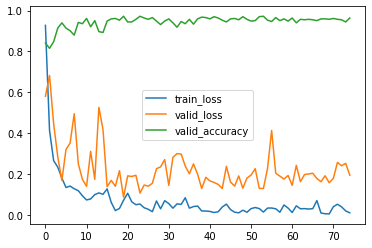

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.081172162316856
TEST
loss: 1.4760624580485846
accuracy: 0.6258064516129033
******************
epoch: 1
Train
0.3816696433656371
TEST
loss: 0.32124809449718844
accuracy: 0.8774193548387097
******************
epoch: 2
Train
0.34564954649073243
TEST
loss: 0.2467316877938086
accuracy: 0.9268817204301075
******************
epoch: 3
Train
0.2790185224644009
TEST
loss: 0.4782628831443607
accuracy: 0.8602150537634409
******************
epoch: 4
Train
0.2490201815521454
TEST
loss: 0.3413605784857145
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.21274466930568123
TEST
loss: 0.4335228135789274
accuracy: 0.8795698924731182
******************
epoch: 6
Train
0.22504544168245297
TEST
loss: 0.2617504736989416
accuracy: 0.9182795698924732
******************
epoch: 7
Train
0.20005362756112988
TEST
loss: 0.3763650394295172
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.16919256886793327
TEST
loss: 0.1891325554700308
accur

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


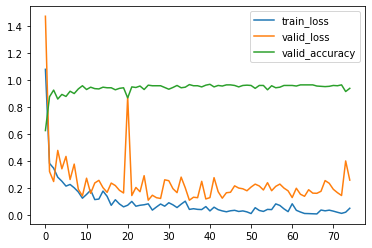

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
2.084605748382511
TEST
loss: 1.6024177689706125
accuracy: 0.5655913978494623
******************
epoch: 1
Train
1.3877696372131283
TEST
loss: 0.7356586284534905
accuracy: 0.7548387096774194
******************
epoch: 2
Train
1.2602496256286506
TEST
loss: 0.785831493203358
accuracy: 0.7505376344086021
******************
epoch: 3
Train
1.1084856402829057
TEST
loss: 0.6177774215257296
accuracy: 0.8344086021505376
******************
epoch: 4
Train
1.1054488419844504
TEST
loss: 0.4273498194192045
accuracy: 0.8709677419354839
******************
epoch: 5
Train
0.9725331591224567
TEST
loss: 1.3164019492364698
accuracy: 0.7311827956989247
******************
epoch: 6
Train
1.0320370804576637
TEST
loss: 0.39885854272432225
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.961227126062462
TEST
loss: 0.4267954396945174
accuracy: 0.8881720430107527
******************
epoch: 8
Train
0.9440613006094675
TEST
loss: 0.34972105346700194
accuracy: 0

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9225473321858864


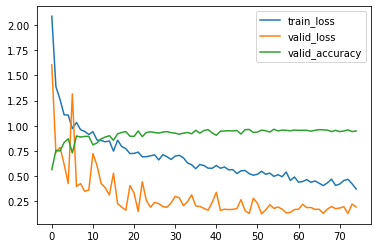

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9512387636725981
TEST
loss: 0.45630585125056644
accuracy: 0.8516129032258064
******************
epoch: 1
Train
0.3911245272373986
TEST
loss: 0.5959602514902751
accuracy: 0.832258064516129
******************
epoch: 2
Train
0.33520052018317087
TEST
loss: 0.25440432821871134
accuracy: 0.9204301075268817
******************
epoch: 3
Train
0.2993913466450856
TEST
loss: 0.4586949972375747
accuracy: 0.8473118279569892
******************
epoch: 4
Train
0.30553637587003446
TEST
loss: 0.6764185938783871
accuracy: 0.8086021505376344
******************
epoch: 5
Train
0.2122127772276287
TEST
loss: 0.2532368620396942
accuracy: 0.9161290322580645
******************
epoch: 6
Train
0.17405921891612525
TEST
loss: 0.15256986493064512
accuracy: 0.9591397849462365
******************
epoch: 7
Train
0.17343821372951174
TEST
loss: 0.4649007694535358
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.1705229083295785
TEST
loss: 0.25193439225355785
acc

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9397590361445783


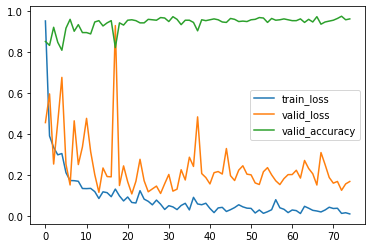

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.9554604787497862
TEST
loss: 1.5274081724946218
accuracy: 0.5526881720430108
******************
epoch: 1
Train
1.3424151438054182
TEST
loss: 0.6965650948145057
accuracy: 0.8193548387096774
******************
epoch: 2
Train
1.2404085920905965
TEST
loss: 1.9028510060361636
accuracy: 0.632258064516129
******************
epoch: 3
Train
1.1042456466405701
TEST
loss: 0.5745113132461425
accuracy: 0.8193548387096774
******************
epoch: 4
Train
1.0769363132676066
TEST
loss: 0.6556066392570413
accuracy: 0.7698924731182796
******************
epoch: 5
Train
0.9932050934772564
TEST
loss: 0.8324747426535494
accuracy: 0.7956989247311828
******************
epoch: 6
Train
1.0522358755174348
TEST
loss: 0.6178353219903926
accuracy: 0.8451612903225807
******************
epoch: 7
Train
0.9309477566324644
TEST
loss: 0.6956081782617877
accuracy: 0.789247311827957
******************
epoch: 8
Train
0.9689906033124087
TEST
loss: 0.4167724097608238
accuracy: 0.

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9328743545611016


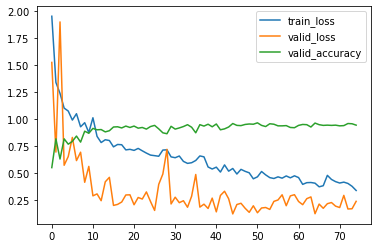

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9074783865071524
TEST
loss: 0.7059632981977155
accuracy: 0.8021505376344086
******************
epoch: 1
Train
0.35145223336509945
TEST
loss: 0.5182376734672054
accuracy: 0.8709677419354839
******************
epoch: 2
Train
0.2721541230885265
TEST
loss: 0.294462455184229
accuracy: 0.9225806451612903
******************
epoch: 3
Train
0.21972755351949907
TEST
loss: 0.3940856190778876
accuracy: 0.8709677419354839
******************
epoch: 4
Train
0.21098078637272039
TEST
loss: 0.30256044358335515
accuracy: 0.8924731182795699
******************
epoch: 5
Train
0.1674483417742472
TEST
loss: 0.3670637570722129
accuracy: 0.8838709677419355
******************
epoch: 6
Train
0.1601502892626956
TEST
loss: 0.33457043452929425
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.16838693116452016
TEST
loss: 0.4439877088351916
accuracy: 0.8559139784946237
******************
epoch: 8
Train
0.09229375553599724
TEST
loss: 0.1854032338446667
accu

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


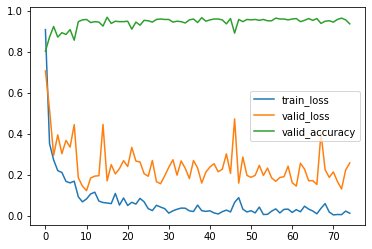

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0206773222680368
TEST
loss: 0.7312302558652817
accuracy: 0.8
******************
epoch: 1
Train
0.43914321130748457
TEST
loss: 0.2765661027482761
accuracy: 0.9032258064516129
******************
epoch: 2
Train
0.3297011171802116
TEST
loss: 0.3260765148747352
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.29993419638871505
TEST
loss: 0.3173748887995238
accuracy: 0.8989247311827957
******************
epoch: 4
Train
0.2802808521637431
TEST
loss: 0.5725922116669275
accuracy: 0.8258064516129032
******************
epoch: 5
Train
0.27580608198831463
TEST
loss: 0.3473729559811213
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.20948900756620245
TEST
loss: 0.1853338638941447
accuracy: 0.9440860215053763
******************
epoch: 7
Train
0.18754297216043206
TEST
loss: 0.21512266487203618
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.16562304895333083
TEST
loss: 0.16649222498939883
accuracy: 0.94193

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


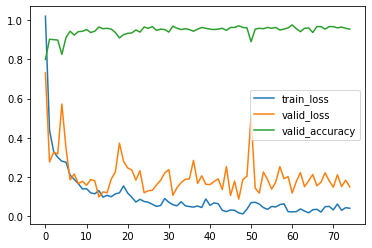

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9362156534297658
TEST
loss: 0.8175890348290884
accuracy: 0.789247311827957
******************
epoch: 1
Train
0.32511654180034744
TEST
loss: 0.2655845901017548
accuracy: 0.9182795698924732
******************
epoch: 2
Train
0.30970132447213466
TEST
loss: 0.4391730555924036
accuracy: 0.853763440860215
******************
epoch: 3
Train
0.2852567804151796
TEST
loss: 0.30803649566506824
accuracy: 0.9010752688172043
******************
epoch: 4
Train
0.16491330260542303
TEST
loss: 0.45231714189373035
accuracy: 0.8666666666666667
******************
epoch: 5
Train
0.16476197246267518
TEST
loss: 0.3882357269845983
accuracy: 0.896774193548387
******************
epoch: 6
Train
0.18322839750419334
TEST
loss: 0.8239110031435567
accuracy: 0.8301075268817204
******************
epoch: 7
Train
0.13803072320272283
TEST
loss: 0.21380144130158169
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.13100956036123976
TEST
loss: 0.2887497999334848
acc

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


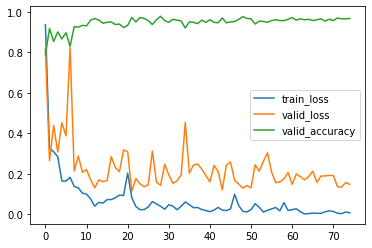

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9369317532612806
TEST
loss: 0.9649795711681407
accuracy: 0.7182795698924731
******************
epoch: 1
Train
0.41808847810994826
TEST
loss: 0.36125165736803444
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.3336939300717881
TEST
loss: 0.3901946408934491
accuracy: 0.8838709677419355
******************
epoch: 3
Train
0.2730615901799374
TEST
loss: 0.41366076587989764
accuracy: 0.8795698924731182
******************
epoch: 4
Train
0.2691175327483338
TEST
loss: 0.372940852052422
accuracy: 0.9118279569892473
******************
epoch: 5
Train
0.2248669416274059
TEST
loss: 0.40271667091436286
accuracy: 0.8989247311827957
******************
epoch: 6
Train
0.22246456126981867
TEST
loss: 0.16763821073697618
accuracy: 0.946236559139785
******************
epoch: 7
Train
0.16393020753505477
TEST
loss: 0.24726210383958713
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.16741405314313
TEST
loss: 0.2190061389368468
accura

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


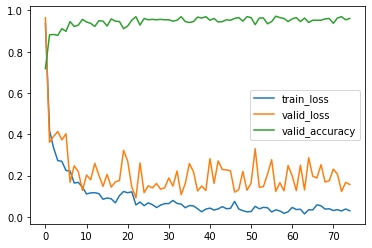

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9706760456180726
TEST
loss: 0.9730297628269401
accuracy: 0.7569892473118279
******************
epoch: 1
Train
0.3777902646609128
TEST
loss: 0.3144720497310802
accuracy: 0.9032258064516129
******************
epoch: 2
Train
0.3008212582295982
TEST
loss: 0.24925949701698877
accuracy: 0.9139784946236559
******************
epoch: 3
Train
0.27066506422137343
TEST
loss: 0.9471750615745462
accuracy: 0.7526881720430108
******************
epoch: 4
Train
0.2233973365351277
TEST
loss: 0.18702299578856396
accuracy: 0.9397849462365592
******************
epoch: 5
Train
0.17170635379317248
TEST
loss: 0.19485672616189526
accuracy: 0.9311827956989247
******************
epoch: 6
Train
0.16228787519948484
TEST
loss: 0.4801445297015611
accuracy: 0.864516129032258
******************
epoch: 7
Train
0.13724157891818511
TEST
loss: 0.37098761309859574
accuracy: 0.9053763440860215
******************
epoch: 8
Train
0.2240682780285259
TEST
loss: 0.6499097140886451
acc

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


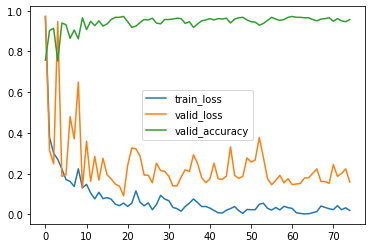

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.3099648646918047
TEST
loss: 0.58728424297866
accuracy: 0.8129032258064516
******************
epoch: 1
Train
0.546940003246406
TEST
loss: 0.5822317537441049
accuracy: 0.8279569892473119
******************
epoch: 2
Train
0.5062278331321096
TEST
loss: 0.28669380930162247
accuracy: 0.9053763440860215
******************
epoch: 3
Train
0.3744267384468001
TEST
loss: 0.8377063708920632
accuracy: 0.7720430107526882
******************
epoch: 4
Train
0.3271849279963463
TEST
loss: 0.46078794431942766
accuracy: 0.8451612903225807
******************
epoch: 5
Train
0.3524549661558292
TEST
loss: 0.18029579066781587
accuracy: 0.9397849462365592
******************
epoch: 6
Train
0.26592977501464005
TEST
loss: 0.3279136460955425
accuracy: 0.9204301075268817
******************
epoch: 7
Train
0.2425482672472185
TEST
loss: 0.3188758006659887
accuracy: 0.9075268817204301
******************
epoch: 8
Train
0.25231285603475234
TEST
loss: 0.21793892750496505
accurac

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


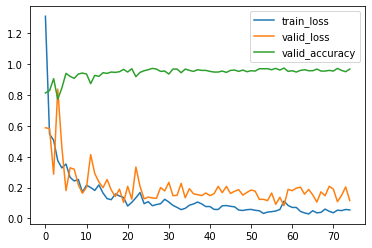

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()